In [1]:
# Librerías estándar y manipulación de archivos
import os
import joblib
import json
import pickle

# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Selección y validación de modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV, StratifiedKFold

# Técnicas de balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

# Configuraciones adicionales
import warnings

# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')

#Se importan las librerias necesarias para el uso de pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Se define el dispositivo a utilizar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)


cuda


In [2]:
def load_data(file_path):
    return joblib.load(file_path)

# Listado de archivos
file_names = [
    "X_test_P1-ALL-ADASYN.pkl", "X_test_P1-ALL.pkl", "X_test_P2-NOCONDITIONS.pkl", "X_test_P3-AGE.pkl",
    "X_test_P4-TIME.pkl", "X_test_P5-HEALTHCENTRE.pkl", "X_train_P1-ALL-ADASYN.pkl", "X_train_P1-ALL.pkl",
    "X_train_P2-NOCONDITIONS.pkl", "X_train_P3-AGE.pkl", "X_train_P4-TIME.pkl", "X_train_P5-HEALTHCENTRE.pkl",
    "y_test_P1-ALL-ADASYN.pkl", "y_test_P1-ALL.pkl", "y_test_P2-NOCONDITIONS.pkl", "y_test_P3-AGE.pkl",
    "y_test_P4-TIME.pkl", "y_test_P5-HEALTHCENTRE.pkl", "y_train_P1-ALL-ADASYN.pkl", "y_train_P1-ALL.pkl",
    "y_train_P2-NOCONDITIONS.pkl", "y_train_P3-AGE.pkl", "y_train_P4-TIME.pkl", "y_train_P5-HEALTHCENTRE.pkl"
]

# Se cargan los archivos en un diccionario
data = {file_name: load_data(os.path.join(file_name)) for file_name in file_names}

# Se extraen los datos de entrenamiento y prueba
X_train = data["X_train_P1-ALL.pkl"]
y_train = data["y_train_P1-ALL.pkl"]
X_test = data["X_test_P1-ALL.pkl"]
y_test = data["y_test_P1-ALL.pkl"]



In [3]:
# Se define la funcion para grafiar la perdida por epoca
def graficar_progreso(losses, inicio_folds, grado=3):
    plt.figure(figsize=(20, 10))
    # Gráfico original
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='blue', label='Pérdida Real')

     # Marcar y anotar el inicio de cada fold
    for i, inicio in enumerate(inicio_folds):
        plt.axvline(x=inicio, color='black', linestyle='--', lw=1)
        plt.text(inicio, max(losses)*0.95, f'Inicio Fold {i+1}', rotation=90, color='black', fontsize=12, fontweight='bold')

    # Ajustando la curva de tendencia
    z = np.polyfit(range(1, len(losses) + 1), losses, grado)  # Ajuste polinomial
    p = np.poly1d(z)  # Creación de un polinomio
    plt.plot(range(1, len(losses) + 1), p(range(1, len(losses) + 1)), "r--", label='Curva de Tendencia')  # Curva de tendencia en rojo

    # Configuración del gráfico
    plt.title('Pérdida por Época a través de los Folds')
    plt.xlabel('Época Total')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# Se define la función para evaluar el modelo
def evaluar_modelo_pytorch(model, X_train_tensor, y_train, X_test_tensor, y_test):
    # Evaluación con datos de entrenamiento
    y_pred = model(X_train_tensor).detach().cpu().numpy()
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Cálculo de métricas para datos de entrenamiento
    accuracy = accuracy_score(y_train, y_pred_bin)
    precision = precision_score(y_train, y_pred_bin)
    recall = recall_score(y_train, y_pred_bin)
    f1 = f1_score(y_train, y_pred_bin)

    # Visualización de métricas y gráficos para datos de entrenamiento
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
    print(f"Accuracy (Datos de Train): {accuracy}")
    print(f"Precision (Datos de Train): {precision}")
    print(f"Recall (Datos de Train): {recall}")
    print(f"F1 Score (Datos de Train): {f1}")

    # Gráficos para datos de entrenamiento
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    conf_matrix = confusion_matrix(y_train, y_pred_bin)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Train)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print (conf_matrix)

    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Train)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Evaluación con datos de prueba
    y_pred_test = model(X_test_tensor).detach().cpu().numpy()
    y_pred_test_bin = (y_pred_test > 0.5).astype(int)

    # Cálculo de métricas para datos de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test_bin)
    precision_test = precision_score(y_test, y_pred_test_bin)
    recall_test = recall_score(y_test, y_pred_test_bin)
    f1_test = f1_score(y_test, y_pred_test_bin)

    # Visualización de métricas y gráficos para datos de prueba
    print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}")
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_test}")

    # Gráficos para datos de prueba
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Test)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print (conf_matrix_test)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Test)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()


Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6206, Val Loss: 0.5787
Fold 1, Epoch 2, Train Loss: 0.5890, Val Loss: 0.5651
Fold 1, Epoch 3, Train Loss: 0.5781, Val Loss: 0.5601
Fold 1, Epoch 4, Train Loss: 0.5709, Val Loss: 0.5531
Fold 1, Epoch 5, Train Loss: 0.5646, Val Loss: 0.5501
Fold 1, Epoch 6, Train Loss: 0.5603, Val Loss: 0.5450
Fold 1, Epoch 7, Train Loss: 0.5562, Val Loss: 0.5422
Fold 1, Epoch 8, Train Loss: 0.5536, Val Loss: 0.5401
Fold 1, Epoch 9, Train Loss: 0.5507, Val Loss: 0.5351
Fold 1, Epoch 10, Train Loss: 0.5472, Val Loss: 0.5342
Fold 1, Epoch 11, Train Loss: 0.5460, Val Loss: 0.5342
Fold 1, Epoch 12, Train Loss: 0.5424, Val Loss: 0.5308
Fold 1, Epoch 13, Train Loss: 0.5420, Val Loss: 0.5273
Fold 1, Epoch 14, Train Loss: 0.5383, Val Loss: 0.5273
Fold 1, Epoch 15, Train Loss: 0.5353, Val Loss: 0.5240
Fold 1, Epoch 16, Train Loss: 0.5345, Val Loss: 0.5232
Fold 1, Epoch 17, Train Loss: 0.5332, Val Loss: 0.5229
Fold 1, Epoch 18, Train Loss: 0.5301, Val Loss: 0.518

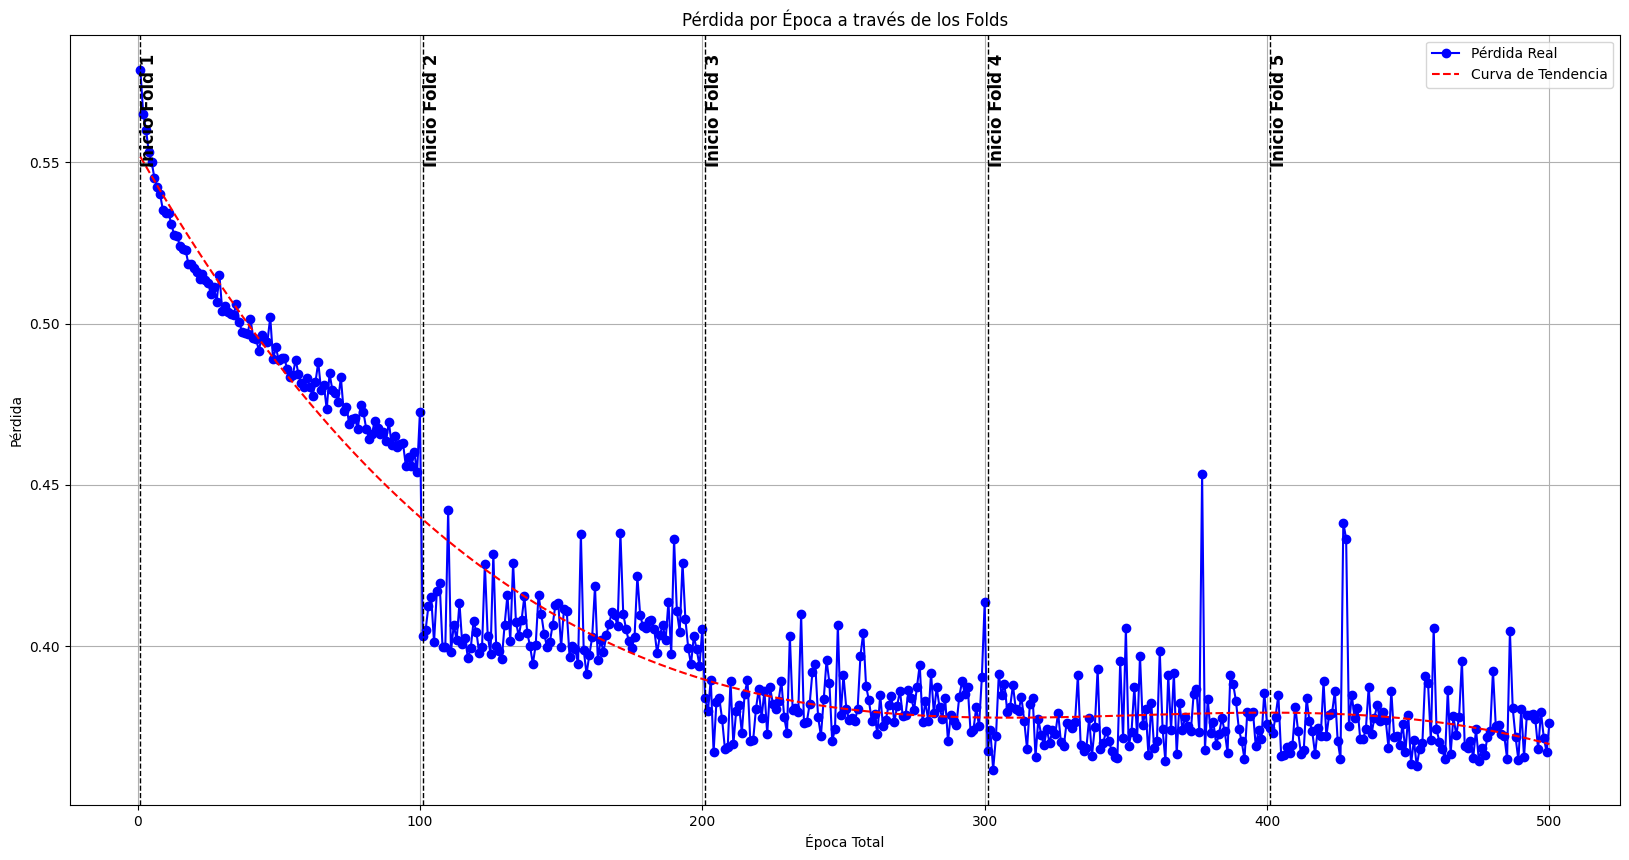

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.8207975026504889
Precision (Datos de Train): 0.7452537356529272
Recall (Datos de Train): 0.9089028282161329
F1 Score (Datos de Train): 0.8189832121927276
[[42317 14116]
 [ 4139 41296]]


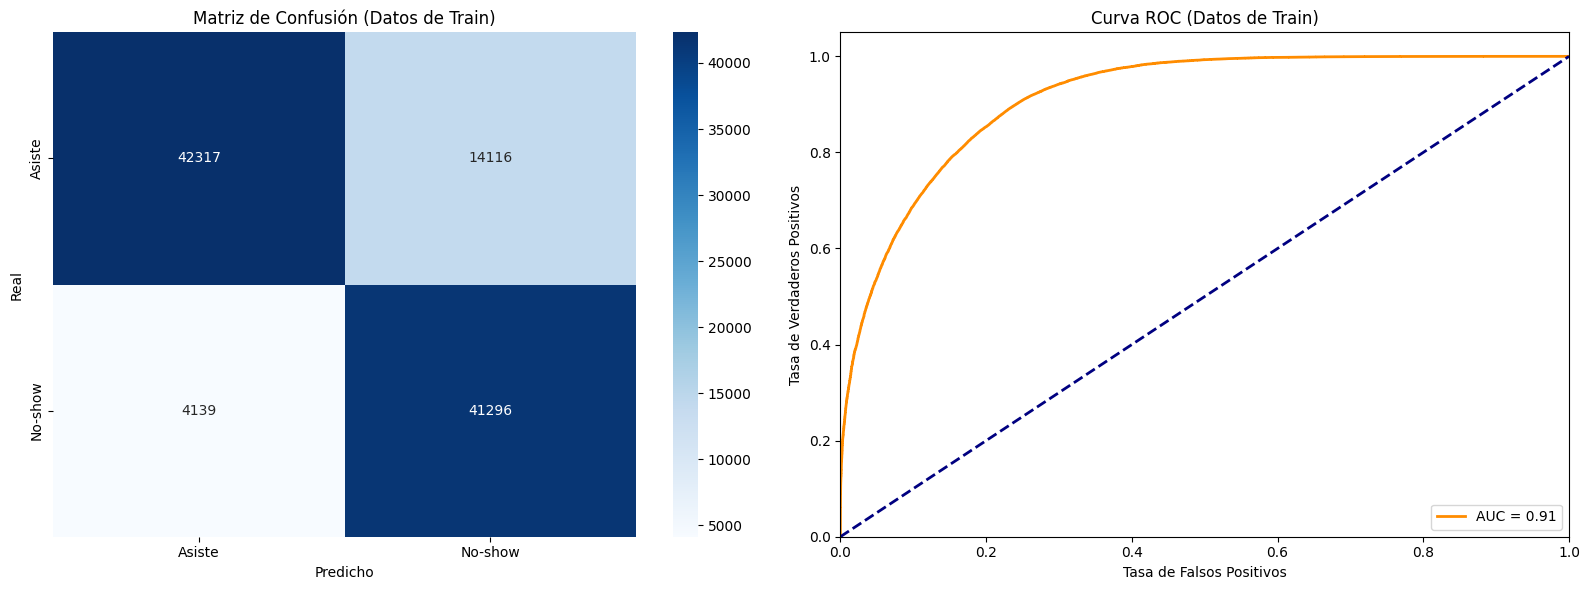

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6661990315427434
Precision (Datos de Test): 0.2969772948878674
Recall (Datos de Test): 0.4779197489352163
F1 Score (Datos de Test): 0.3663230240549828
[[12589  5047]
 [ 2329  2132]]


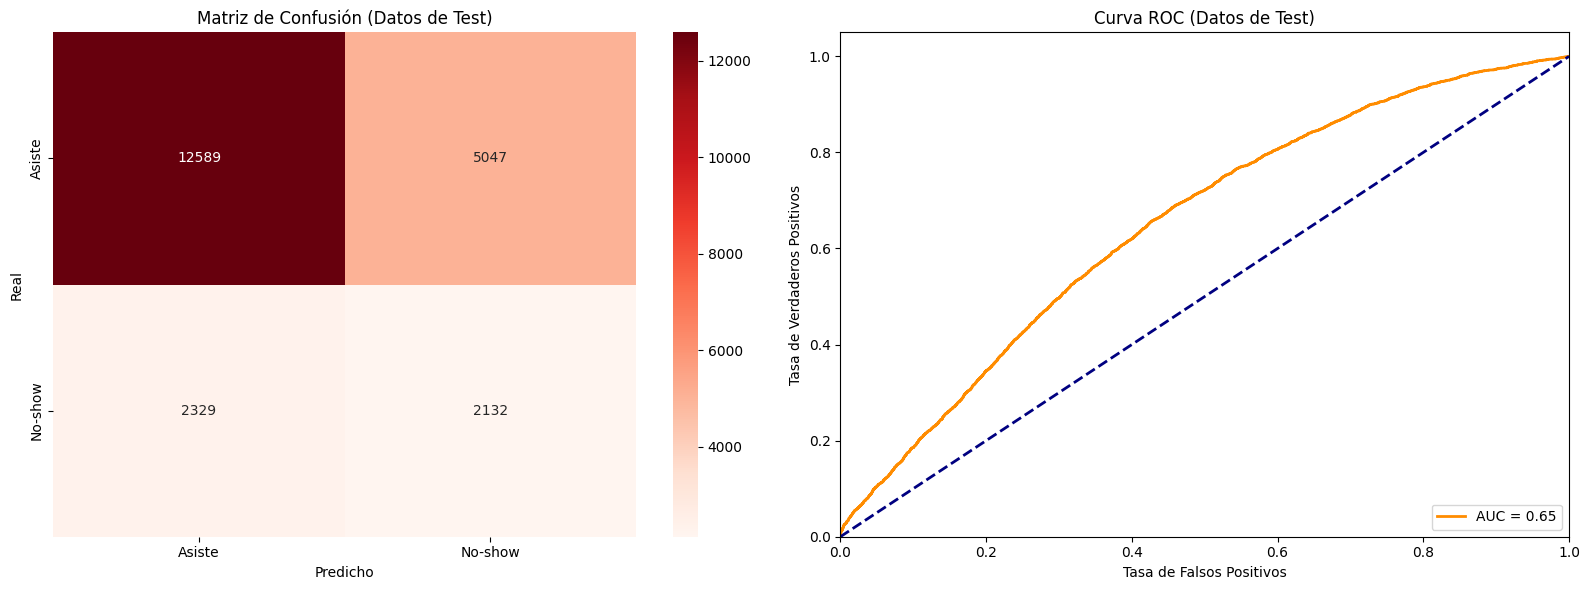

In [5]:
#Se verifica si el modelo ya ha sido entrenado
class NeuralNet(nn.Module):
    # Definir la arquitectura del modelo
        def __init__(self, input_size):
            super(NeuralNet, self).__init__()
            self.layer1 = nn.Linear(input_size, 256) #  Capa oculta 1
            self.bn1 = nn.BatchNorm1d(256) # Batch Normalization (BN), sirve para acelerar el entrenamiento y mejorar la precisión
            self.relu1 = nn.ReLU() # Función de activación ReLU, sirve para introducir no linealidades en la red, permitiendo que el modelo aprenda relaciones más complejas
                
            self.layer2 = nn.Linear(256, 1024) #  Capa oculta 2
            self.relu2 = nn.ReLU()
            self.bn2 = nn.BatchNorm1d(1024) 
            self.dropout1 = nn.Dropout(0.5) # Dropout, sirve para evitar el sobreajuste desactivando aleatoriamente un porcentaje de las neuronas, en este caso, el 50%

            self.layer3 = nn.Linear(1024, 256) # Capa oculta 3
            self.relu3 = nn.ReLU()
            self.bn3 = nn.BatchNorm1d(256) 
            self.dropout2 = nn.Dropout(0.5)

            self.output_layer = nn.Linear(256, 1) # Capa de salida
            self.sigmoid = nn.Sigmoid()
            
        def forward(self, x):
            out = self.bn1(self.layer1(x))  # Primero aplicar BN a la salida de la capa lineal
            out = self.relu1(out)
                
            out = self.bn2(self.layer2(out)) 
            out = self.relu2(out)
            out = self.dropout1(out)
                
            out = self.bn3(self.layer3(out))  
            out = self.relu3(out)
            out = self.dropout2(out)
                
            out = self.output_layer(out)
            out = self.sigmoid(out)
            return out
# Instanciar el modelo
model = NeuralNet(X_train.shape[1]).to(device)

# Se verifica si el modelo ya ha sido entrenado
if os.path.exists('modelo_pytorch.pth'):
    model.load_state_dict(torch.load('modelo_pytorch.pth'))
    print("Modelo cargado desde el archivo.")
else:
    # Se definen los folds
    skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    num_epochs = 100
    fold_results = []
    losses = []
    inicio_folds = [1]  # La primera época siempre es el inicio del primer fold
    epoca_actual = 0

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    for fold, (train_index, test_index) in enumerate(skfolds.split(X_train, y_train)):
        print(f'Comenzando el fold {fold+1}')

        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        X_valid_fold = X_train[test_index]
        y_valid_fold = y_train[test_index]

        X_train_fold_tensor = torch.tensor(X_train_fold).float().to(device)
        y_train_fold_tensor = torch.tensor(y_train_fold.to_numpy()[:, None]).float().to(device)
        X_valid_fold_tensor = torch.tensor(X_valid_fold).float().to(device)
        y_valid_fold_tensor = torch.tensor(y_valid_fold.to_numpy()[:, None]).float().to(device)

        train_loader = DataLoader(TensorDataset(X_train_fold_tensor, y_train_fold_tensor), batch_size=64, shuffle=True)
        valid_loader = DataLoader(TensorDataset(X_valid_fold_tensor, y_valid_fold_tensor), batch_size=64)

        epoch_losses = []

        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            scheduler.step()

            model.eval()
            val_losses = []
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_losses.append(loss.item())

            epoch_train_loss = torch.tensor(train_losses).mean().item()
            epoch_val_loss = torch.tensor(val_losses).mean().item()
            epoch_losses.append((epoch_train_loss, epoch_val_loss))
            # Se añade la pérdida de validación a la lista global
            losses.append(epoch_val_loss)
            print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        fold_results.append({
            'fold': fold+1,
            'epoch_losses': epoch_losses,
        })
        # Se añade el número de la última época de este fold al inicio de la lista
        if fold < skfolds.n_splits - 1:
            epoca_actual += num_epochs
            inicio_folds.append(epoca_actual + 1)

    # Se guarda el modelo
    torch.save(model.state_dict(), 'modelo_pytorch.pth')

# Se grafica el progreso de la pérdida a través de los folds
graficar_progreso(losses, inicio_folds, grado=3)

# Se convierten los datos de test a tensores
X_test_tensor = torch.tensor(X_test).float().to(device)

# Se evalúa el modelo entrenado
evaluar_modelo_pytorch(model, X_train_fold_tensor, y_train_fold, X_test_tensor, y_test)